# Building Agentic Document Understanding

build an agent that combines tools for OCR, layout detection, reading order and VLM.

## Architecture Overview

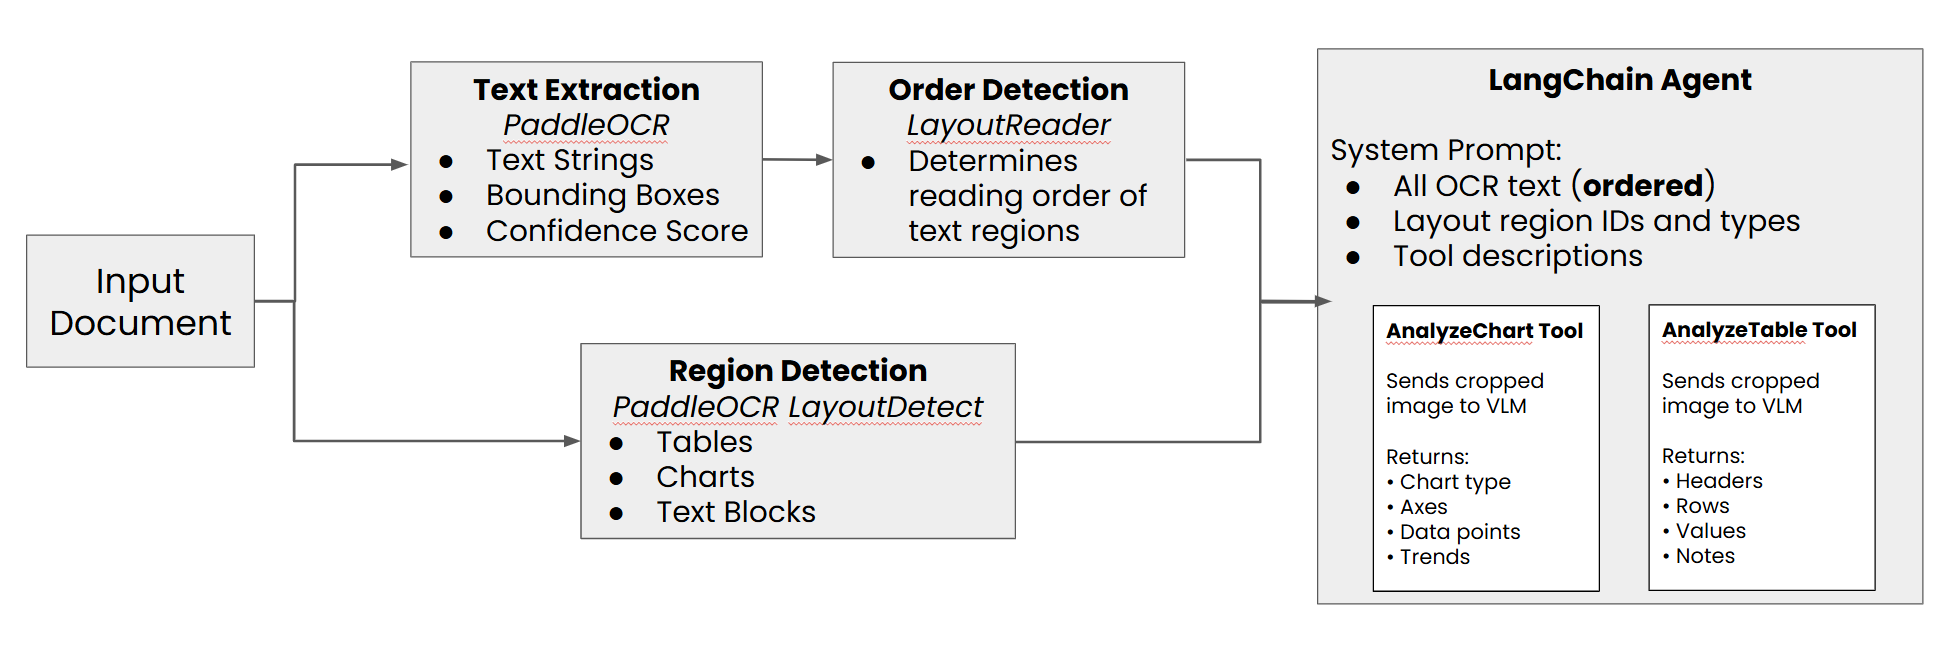

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ade/lab3/

Mounted at /content/drive
/content/drive/MyDrive/ade/lab3


In [2]:
!pip install -qU langchain langchain-groq pytesseract "paddleocr[all]" paddlepaddle
!git clone https://github.com/ppaanngggg/layoutreader.git
!pip install -r layoutreader/requirements.txt
import os
import sys

file_path = '/usr/local/lib/python3.12/dist-packages/paddlex/inference/pipelines/components/retriever/base.py'

if not os.path.exists(file_path):
    version = f"{sys.version_info.major}.{sys.version_info.minor}"
    file_path = f'/usr/local/lib/python{version}/dist-packages/paddlex/inference/pipelines/components/retriever/base.py'

if os.path.exists(file_path):
    print(f"Found file at: {file_path}")

    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    old_text_1 = 'from langchain.docstore.document import Document'
    old_text_2 = 'from langchain.text_splitter import RecursiveCharacterTextSplitter'

    new_text_1 = 'from langchain_core.documents import Document'
    new_text_2 = 'from langchain_text_splitters import RecursiveCharacterTextSplitter'

    if old_text_1 in content or old_text_2 in content:
        new_content = content.replace(old_text_1, new_text_1)
        new_content = new_content.replace(old_text_2, new_text_2)

        with open(file_path, 'w', encoding='utf-8') as f:
            f.write(new_content)

        print("✅ Patch applied successfully!")
    else:
        print("⚠️ Old text not found. The file might have been patched already.")

else:
    print(f"❌ File not found at: {file_path}")
    print("Ensure paddlex is installed correctly.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import re
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List

import cv2
from paddleocr import PaddleOCR
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from google.colab import userdata
from IPython.display import display
from PIL import Image

# LangChain Imports
from langchain.agents import create_agent
from langchain.tools import tool
from langchain_core.messages import HumanMessage
from langchain_groq import ChatGroq

# Setup API Key
GROQ_API_KEY = userdata.get('GROQ_API')



<a id="1"></a>

## Text Extraction with PaddleOCR + LayoutLM Ordering

Extract text and determine reading order using PaddleOCR and LayoutLM.

PaddleOCR returns three components for each detected text region:
- **Recognized text** strings
- **Confidence scores**
- **Bounding box coordinates** (4-point polygons)

/usr/local/lib/python3.12/dist-packages/paddle/utils/cpp_extension/extension_utils.py:712: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in `/root/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in `/root/.paddlex/official_models/UVDoc`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in `/root/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in `/root/.paddlex/official_models/PP-OCRv5_server_det`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('en_PP-OCRv5_mobile_rec', None)
Using official model (en_PP-OCRv5_mobile_rec), the model files will be automatically downloaded and saved in `/root/.paddlex/official_models/en_PP-OCRv5_mobile_rec`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

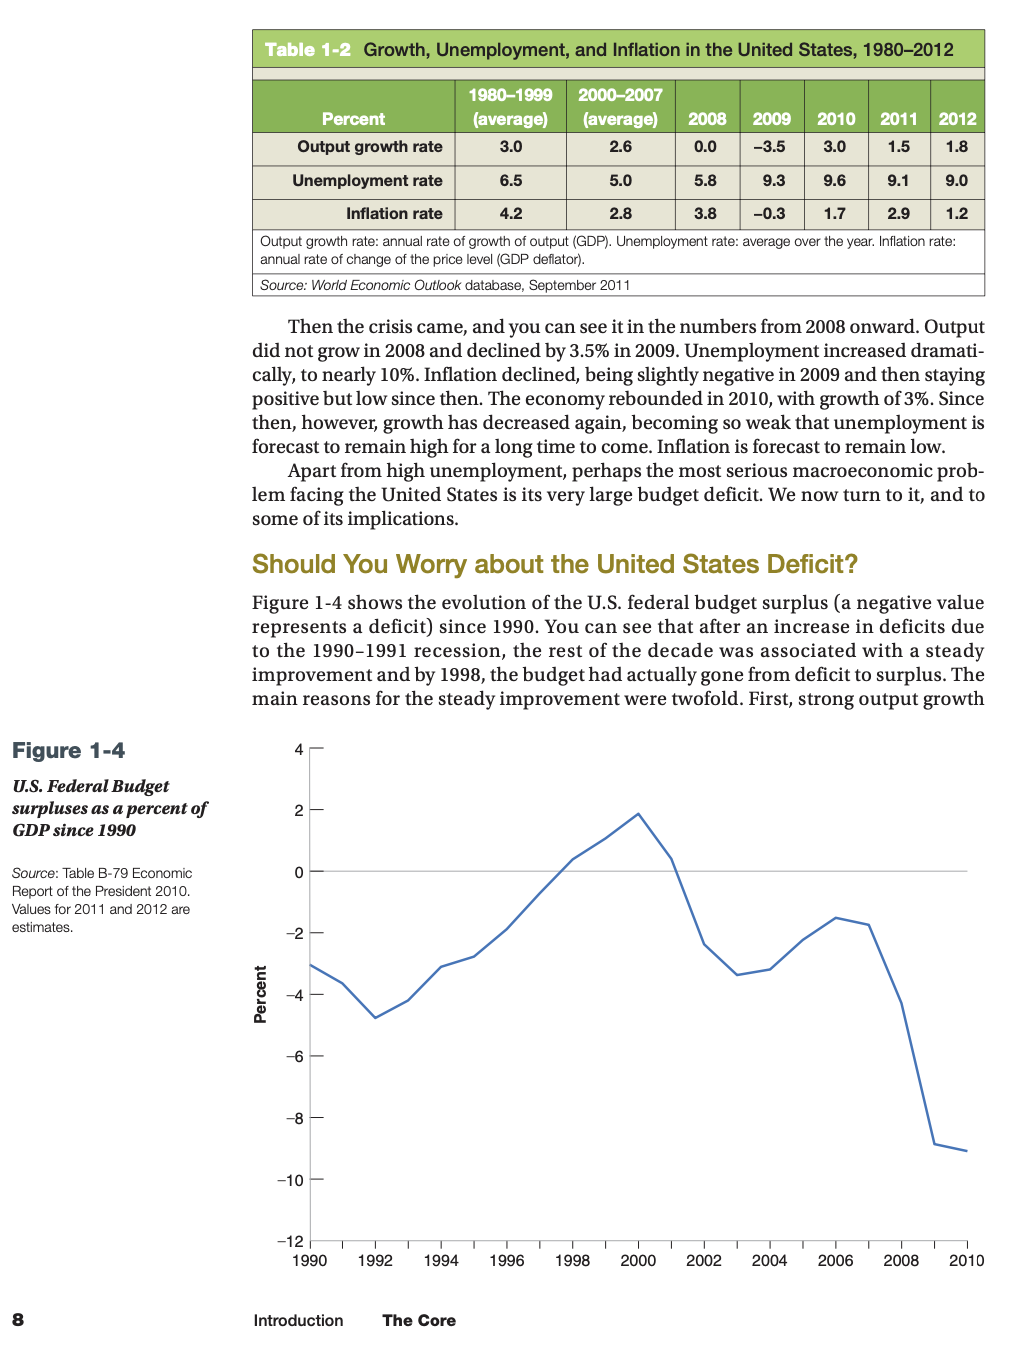

In [4]:
# Initialize PaddleOCR
ocr = PaddleOCR(lang='en', enable_mkldnn=False)

# Load image
image_path = "report_original.png"
display(Image.open(image_path))

In [5]:
# Running OCR on the Document
result = ocr.predict(image_path)
page = result[0]

texts = page['rec_texts']      # recognized text strings
scores = page['rec_scores']    # confidence scores
boxes = page['rec_polys']      # bounding box coordinates

print(f"Extracted {len(texts)} text regions")
print("\nFirst 10 regions:")
for text, score, box in list(zip(texts, scores, boxes))[:10]:
    coords = box.astype(int).tolist()
    print(f"{text:40} | {score:.3f} | {coords}")

Extracted 82 text regions

First 10 regions:
Table 1-2 Growth, Unemployment, and Inflation in the United States, 19802012 | 0.977 | [[221, 13], [986, 7], [986, 38], [222, 44]]
19801999                                 | 1.000 | [[443, 66], [541, 66], [541, 87], [443, 87]]
20002007                                 | 1.000 | [[561, 65], [661, 62], [662, 87], [561, 89]]
Percent                                  | 1.000 | [[287, 91], [362, 91], [362, 116], [287, 116]]
(average)                                | 1.000 | [[446, 89], [537, 91], [536, 120], [445, 118]]
(average)                                | 1.000 | [[565, 90], [655, 88], [656, 116], [565, 118]]
2008                                     | 1.000 | [[679, 87], [731, 87], [731, 113], [679, 113]]
2009                                     | 1.000 | [[750, 86], [800, 86], [800, 112], [750, 112]]
2010                                     | 1.000 | [[822, 88], [873, 88], [873, 111], [822, 111]]
2011                                     | 1

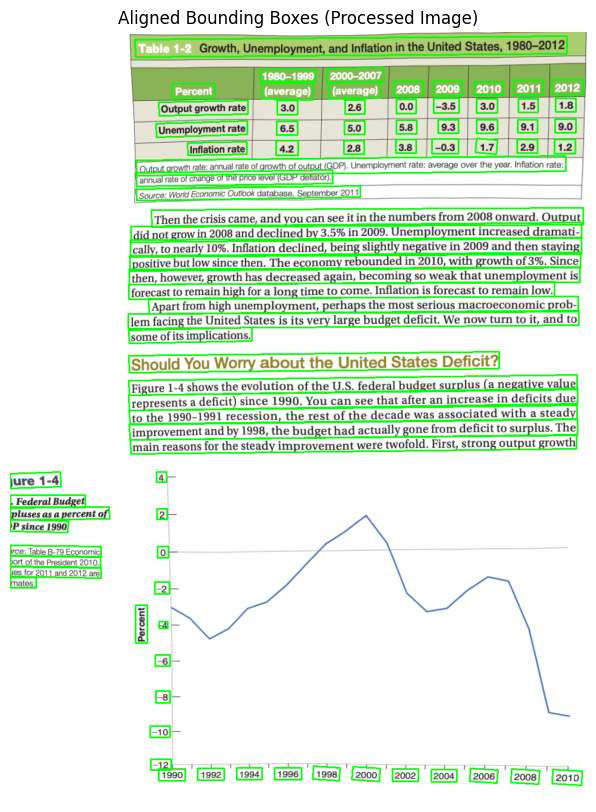

In [6]:
# Visualizing OCR Bounding Boxes
processed_img = page['doc_preprocessor_res']['output_img']
img_plot = processed_img.copy()
show_text= False

for text, box in zip(texts, boxes):
    pts = np.array(box, dtype=int)
    cv2.polylines(img_plot, [pts], True, (0, 255, 0), 2)
    x, y = pts[0]
    if show_text:
        cv2.putText(img_plot, text, (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

plt.figure(figsize=(8, 10))
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Aligned Bounding Boxes (Processed Image)")
plt.show()

In [7]:
# Structuring OCR Results with a Dataclass
@dataclass
class OCRRegion:
  text: str
  bbox: list
  confidence: float

  @property
  def bbox_xyxy(self):
    """Return bbox as [x1, y1, x2, y2] format."""
    x_coords = [p[0] for p in self.bbox]
    y_coords = [p[1] for p in self.bbox]
    return [min(x_coords), min(y_coords), max(x_coords), max(y_coords)]

ocr_regions: List[OCRRegion] = []
for text, score, box in zip(texts, scores, boxes):
    ocr_regions.append(OCRRegion(
        text=text,
        bbox=box.astype(int).tolist(),
        confidence=score
    ))

print(f"Stored {len(ocr_regions)} OCR regions")

Stored 82 OCR regions


In [8]:
# LayoutLM Reading Order
from transformers import LayoutLMv3ForTokenClassification
from layoutreader.v3.helpers import prepare_inputs, boxes2inputs, parse_logits

# Load LayoutReader model
print("Loading LayoutReader model...")
model_slug = "hantian/layoutreader"
layout_model = LayoutLMv3ForTokenClassification.from_pretrained(model_slug)
print("Model loaded successfully!")

Loading LayoutReader model...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/713M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/400 [00:00<?, ?it/s]

Model loaded successfully!


In [9]:
def get_reading_order(ocr_regions):
    """
    Use LayoutReader to determine reading order of OCR regions.
    Returns list of reading order positions for each region index.
    """
    # 1. Calculate image dimensions from bounding boxes (with padding)
    max_x = max_y = 0
    for region in ocr_regions:
        x1, y1, x2, y2 = region.bbox_xyxy
        max_x = max(max_x, x2)
        max_y = max(max_y, y2)

    image_width = max_x * 1.1   # Add 10% padding
    image_height = max_y * 1.1

    # 2. Convert bboxes to LayoutReader format (normalized to 0-1000)
    boxes = []
    for region in ocr_regions:
        x1, y1, x2, y2 = region.bbox_xyxy
        # Normalize to 0-1000 range
        left = int((x1 / image_width) * 1000)
        top = int((y1 / image_height) * 1000)
        right = int((x2 / image_width) * 1000)
        bottom = int((y2 / image_height) * 1000)
        boxes.append([left, top, right, bottom])

    # 3. Prepare inputs
    inputs = boxes2inputs(boxes)
    inputs = prepare_inputs(inputs, layout_model)

    # 4. Run inference
    logits = layout_model(**inputs).logits.cpu().squeeze(0)

    # 5. Parse the model's outputs to get reading order
    reading_order = parse_logits(logits, len(boxes))

    return reading_order

# Get reading order
reading_order = get_reading_order(ocr_regions)

print(f"Reading order determined for {len(reading_order)} regions")
print(f"First 20 positions: {reading_order[:20]}")

Reading order determined for 82 regions
First 20 positions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


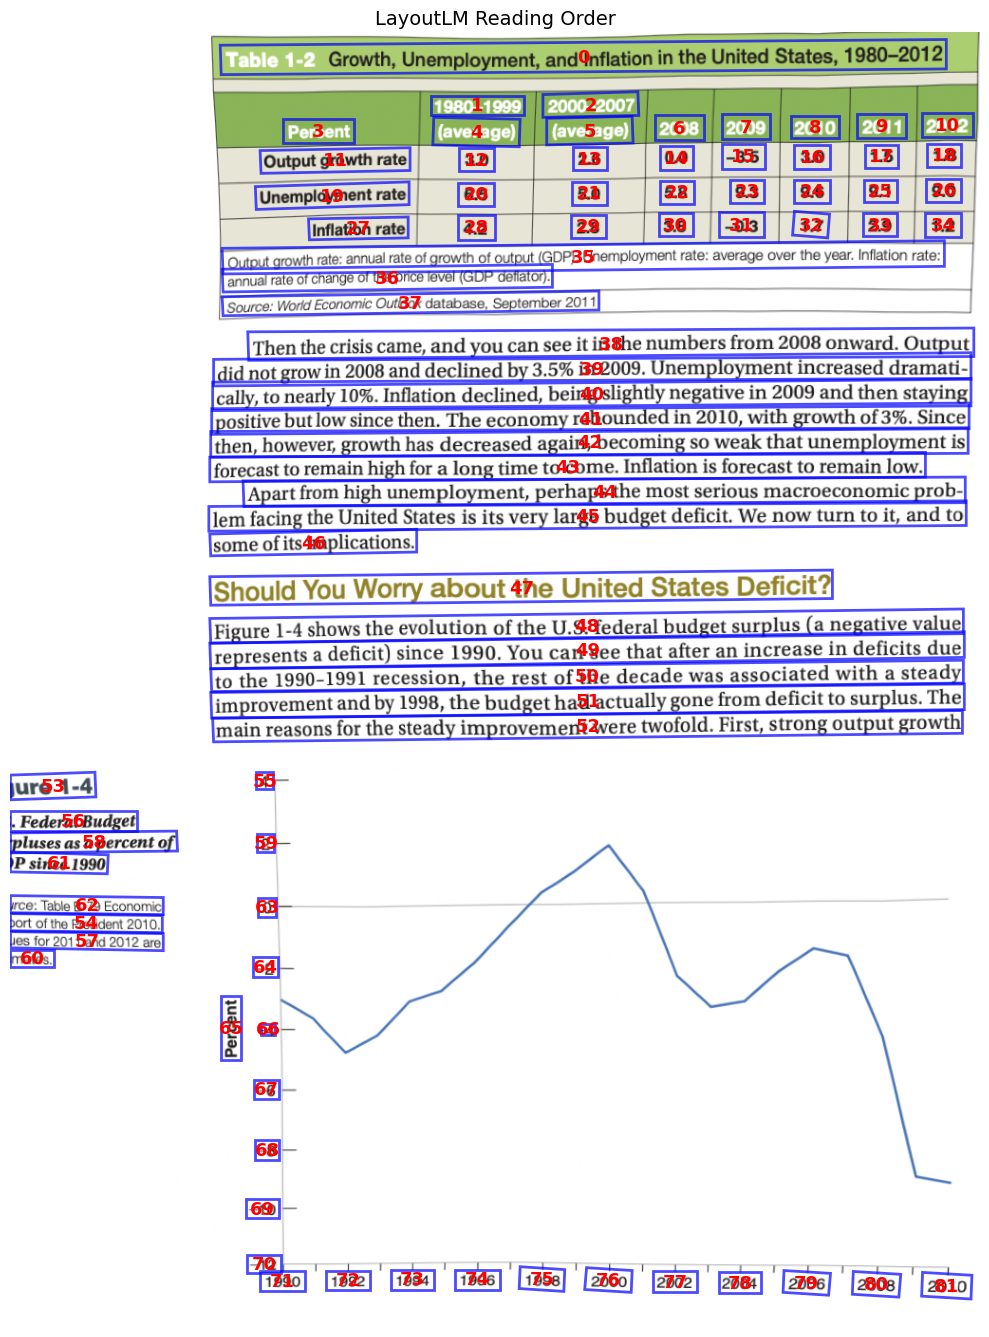

In [10]:
# Visualizing the Reading Order
def visualize_reading_order(ocr_regions, image_array, reading_order, title="Reading Order"):
    """
    Visualize OCR regions with their reading order numbers using matplotlib.
    """

    fig, ax = plt.subplots(1, figsize=(10, 14))
    ax.imshow(cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB))

    # Create order mapping: index -> reading order position
    order_map = {i: order for i, order in enumerate(reading_order)}

    for i, region in enumerate(ocr_regions):
        bbox = region.bbox
        if bbox and len(bbox) >= 4:
            # Draw polygon
            ax.add_patch(patches.Polygon(bbox, linewidth=2,
                                         edgecolor='blue',
                                         facecolor='none', alpha=0.7))
            # Add reading order number at center
            xs = [p[0] for p in bbox]
            ys = [p[1] for p in bbox]
            ax.text(sum(xs)/len(xs), sum(ys)/len(ys),
                    str(order_map.get(i, i)),
                    fontsize=13, color='red',
                    ha='center', va='center', fontweight='bold')

    ax.set_title(title, fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_reading_order(ocr_regions, processed_img,
                        reading_order, "LayoutLM Reading Order")

In [11]:
# Creating the Ordered Text Output
def get_ordered_text(ocr_regions, reading_order):
    """
    Return OCR regions sorted by reading order
    with their text and confidence.
    """
    # 1. Create (reading_position, index, region) tuples and sort
    indexed_regions = [(reading_order[i],
                        i,
                        ocr_regions[i]) for i in range(len(ocr_regions))]

    # 2. Sort by reading position
    indexed_regions.sort(key=lambda x: x[0])

    # 3. Extract ordered text info
    ordered_text = []
    for position, original_idx, region in indexed_regions:
        ordered_text.append({
            "position": position,
            "text": region.text,
            "confidence": region.confidence,
            "bbox": region.bbox_xyxy
        })

    return ordered_text

ordered_text = get_ordered_text(ocr_regions, reading_order)

print("Text in reading order:")
print("=" * 70)
ordered_text[:5]

Text in reading order:


[{'position': 0,
  'text': 'Table 1-2 Growth, Unemployment, and Inflation in the United States, 19802012',
  'confidence': 0.9769929647445679,
  'bbox': [221, 7, 986, 44]},
 {'position': 1,
  'text': '19801999',
  'confidence': 0.9999632239341736,
  'bbox': [443, 66, 541, 87]},
 {'position': 2,
  'text': '20002007',
  'confidence': 0.9998123645782471,
  'bbox': [561, 62, 662, 89]},
 {'position': 3,
  'text': 'Percent',
  'confidence': 0.9999251365661621,
  'bbox': [287, 91, 362, 116]},
 {'position': 4,
  'text': '(average)',
  'confidence': 0.9999572038650513,
  'bbox': [445, 89, 537, 120]}]

# Layout Detection with PaddleOCR

PaddleOCR's `LayoutDetection` identifies document structure. Each region includes:
- **label**: Content type (text, table, chart, figure, etc.)
- **score**: Confidence score
- **bbox**: Bounding box in XYXY format


In [12]:
from paddleocr import LayoutDetection

# Initialize layout detection
layout_engine = LayoutDetection(enable_mkldnn=False)

Using official model (PP-DocLayout_plus-L), the model files will be automatically downloaded and saved in `/root/.paddlex/official_models/PP-DocLayout_plus-L`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
# Process document layout
def process_document(image_path):
    """Get layout regions from document."""
    layout_result = layout_engine.predict(image_path)

    regions = []
    for box in layout_result[0]['boxes']:
        regions.append({
            'label': box['label'],
            'score': box['score'],
            'bbox': box['coordinate'],  # [x1, y1, x2, y2]
        })

    # Sort by confidence
    regions = sorted(regions, key=lambda x: x['score'], reverse=True)
    return regions

layout_results = process_document(image_path)

print(f"Detected {len(layout_results)} layout regions:")
for r in layout_results:
    print(f"  {r['label']:20} score: {r['score']:.3f}  bbox: {[int(x) for x in r['bbox']]}")

Detected 15 layout regions:
  text                 score: 0.983  bbox: [245, 315, 983, 454]
  text                 score: 0.976  bbox: [245, 590, 982, 707]
  text                 score: 0.973  bbox: [246, 460, 983, 526]
  chart                score: 0.973  bbox: [249, 737, 982, 1271]
  paragraph_title      score: 0.926  bbox: [247, 550, 857, 573]
  text                 score: 0.847  bbox: [7, 863, 191, 932]
  number               score: 0.823  bbox: [12, 1311, 24, 1324]
  table                score: 0.751  bbox: [251, 69, 983, 293]
  footer               score: 0.735  bbox: [250, 1310, 455, 1326]
  table                score: 0.713  bbox: [251, 74, 982, 227]
  figure_title         score: 0.707  bbox: [261, 37, 953, 58]
  text                 score: 0.661  bbox: [256, 275, 629, 291]
  text                 score: 0.594  bbox: [8, 775, 207, 836]
  paragraph_title      score: 0.582  bbox: [8, 738, 125, 759]
  text                 score: 0.531  bbox: [255, 232, 958, 267]


In [14]:
# Top five detected regions
layout_results[0:5]

[{'label': 'text',
  'score': 0.9832395911216736,
  'bbox': [np.float32(245.83952),
   np.float32(315.08884),
   np.float32(983.7128),
   np.float32(454.9893)]},
 {'label': 'text',
  'score': 0.97642982006073,
  'bbox': [np.float32(245.74294),
   np.float32(590.87726),
   np.float32(982.70496),
   np.float32(707.906)]},
 {'label': 'text',
  'score': 0.9731148481369019,
  'bbox': [np.float32(246.21632),
   np.float32(460.42502),
   np.float32(983.4213),
   np.float32(526.6739)]},
 {'label': 'chart',
  'score': 0.9727388620376587,
  'bbox': [np.float32(249.72404),
   np.float32(737.7183),
   np.float32(982.07153),
   np.float32(1271.0194)]},
 {'label': 'paragraph_title',
  'score': 0.9260664582252502,
  'bbox': [np.float32(247.40001),
   np.float32(550.68463),
   np.float32(857.2249),
   np.float32(573.2926)]}]

In [15]:
# Structuring Layout Results
@dataclass
class LayoutRegion:
    region_id: int
    region_type: str
    bbox: list
    confidence: float


# Store layout regions in structured format
layout_regions: List[LayoutRegion] = []

for i, r in enumerate(layout_results):
    layout_regions.append(LayoutRegion(
        region_id=i,
        region_type=r['label'],
        bbox=[int(x) for x in r['bbox']],
        confidence=r['score']
    ))

print(f"Stored {len(layout_regions)} layout regions")

Stored 15 layout regions


In [16]:
layout_regions

[LayoutRegion(region_id=0, region_type='text', bbox=[245, 315, 983, 454], confidence=0.9832395911216736),
 LayoutRegion(region_id=1, region_type='text', bbox=[245, 590, 982, 707], confidence=0.97642982006073),
 LayoutRegion(region_id=2, region_type='text', bbox=[246, 460, 983, 526], confidence=0.9731148481369019),
 LayoutRegion(region_id=3, region_type='chart', bbox=[249, 737, 982, 1271], confidence=0.9727388620376587),
 LayoutRegion(region_id=4, region_type='paragraph_title', bbox=[247, 550, 857, 573], confidence=0.9260664582252502),
 LayoutRegion(region_id=5, region_type='text', bbox=[7, 863, 191, 932], confidence=0.847410261631012),
 LayoutRegion(region_id=6, region_type='number', bbox=[12, 1311, 24, 1324], confidence=0.8233112692832947),
 LayoutRegion(region_id=7, region_type='table', bbox=[251, 69, 983, 293], confidence=0.7506426572799683),
 LayoutRegion(region_id=8, region_type='footer', bbox=[250, 1310, 455, 1326], confidence=0.7346779704093933),
 LayoutRegion(region_id=9, regio

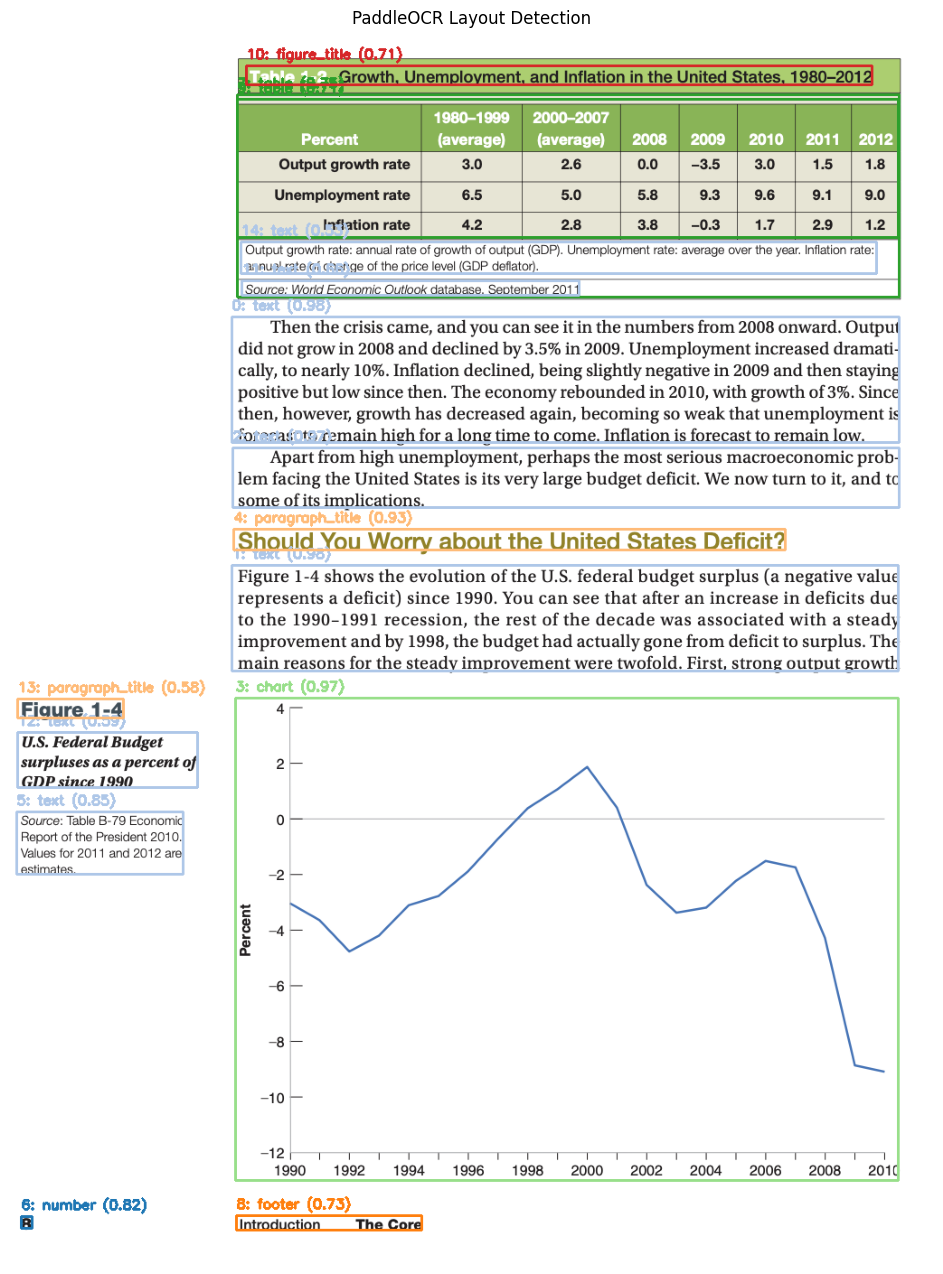

In [17]:
# Visualize layout detection
from matplotlib import colormaps

def visualize_layout(image_path, layout_regions, min_confidence=0.5,
                     title="Layout Detection"):
    """
    Visualize layout detection results using cv2 (same pattern as L2).
    """
    img = cv2.imread(image_path)
    img_plot = img.copy()

    # Get unique labels and generate colors
    labels = list(set(r.region_type for r in layout_regions))
    cmap = colormaps.get_cmap('tab20')
    color_map = {}
    for i, label in enumerate(labels):
        rgba = cmap(i % 20)
        color_map[label] = (int(rgba[2]*255), int(rgba[1]*255), int(rgba[0]*255))

    for region in layout_regions:
        if region.confidence < min_confidence:
            continue

        color = color_map[region.region_type]
        x1, y1, x2, y2 = region.bbox

        # Draw rectangle
        pts = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], dtype=int)
        cv2.polylines(img_plot, [pts], True, color, 2)

        # Add label
        text = f"{region.region_id}: {region.region_type} ({region.confidence:.2f})"
        cv2.putText(img_plot, text, (x1, y1-8),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    plt.figure(figsize=(12, 16))
    plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(title)
    plt.show()

    return img_plot

visualize_layout(image_path, layout_regions,
                 min_confidence=0.5, title="PaddleOCR Layout Detection");

## Cropping Regions for Agent Tools

Prepare cropped regions for VLM analysis:
- **Focused analysis** - VLM sees only relevant content
- **Reduced noise** - No surrounding text interference
- **Lower costs** - Smaller images reduce API costs

Images are base64-encoded for vision API compatibility.

In [18]:
import base64
from io import BytesIO

# Crop and save layout regions for agent tools
def crop_region(image, bbox, padding=10):
    """Crop a region from image with optional padding."""
    x1, y1, x2, y2 = bbox
    x1 = max(0, x1 - padding)
    y1 = max(0, y1 - padding)
    x2 = min(image.width, x2 + padding)
    y2 = min(image.height, y2 + padding)
    return image.crop((x1, y1, x2, y2))

def image_to_base64(img):
    """Convert PIL Image to base64 string."""
    buffer = BytesIO()
    img.save(buffer, format='PNG')
    return base64.b64encode(buffer.getvalue()).decode('utf-8')

# Load image for cropping
pil_image = Image.open(image_path)

# Store cropped regions in dictionary
region_images = {}
for region in layout_regions:
    cropped = crop_region(pil_image, region.bbox)
    region_images[region.region_id] = {
        'image': cropped,
        'base64': image_to_base64(cropped),
        'type': region.region_type,
        'bbox': region.bbox
    }

print(f"Cropped {len(region_images)} regions")

# Also store full image
full_image_base64 = image_to_base64(pil_image)

Cropped 15 regions


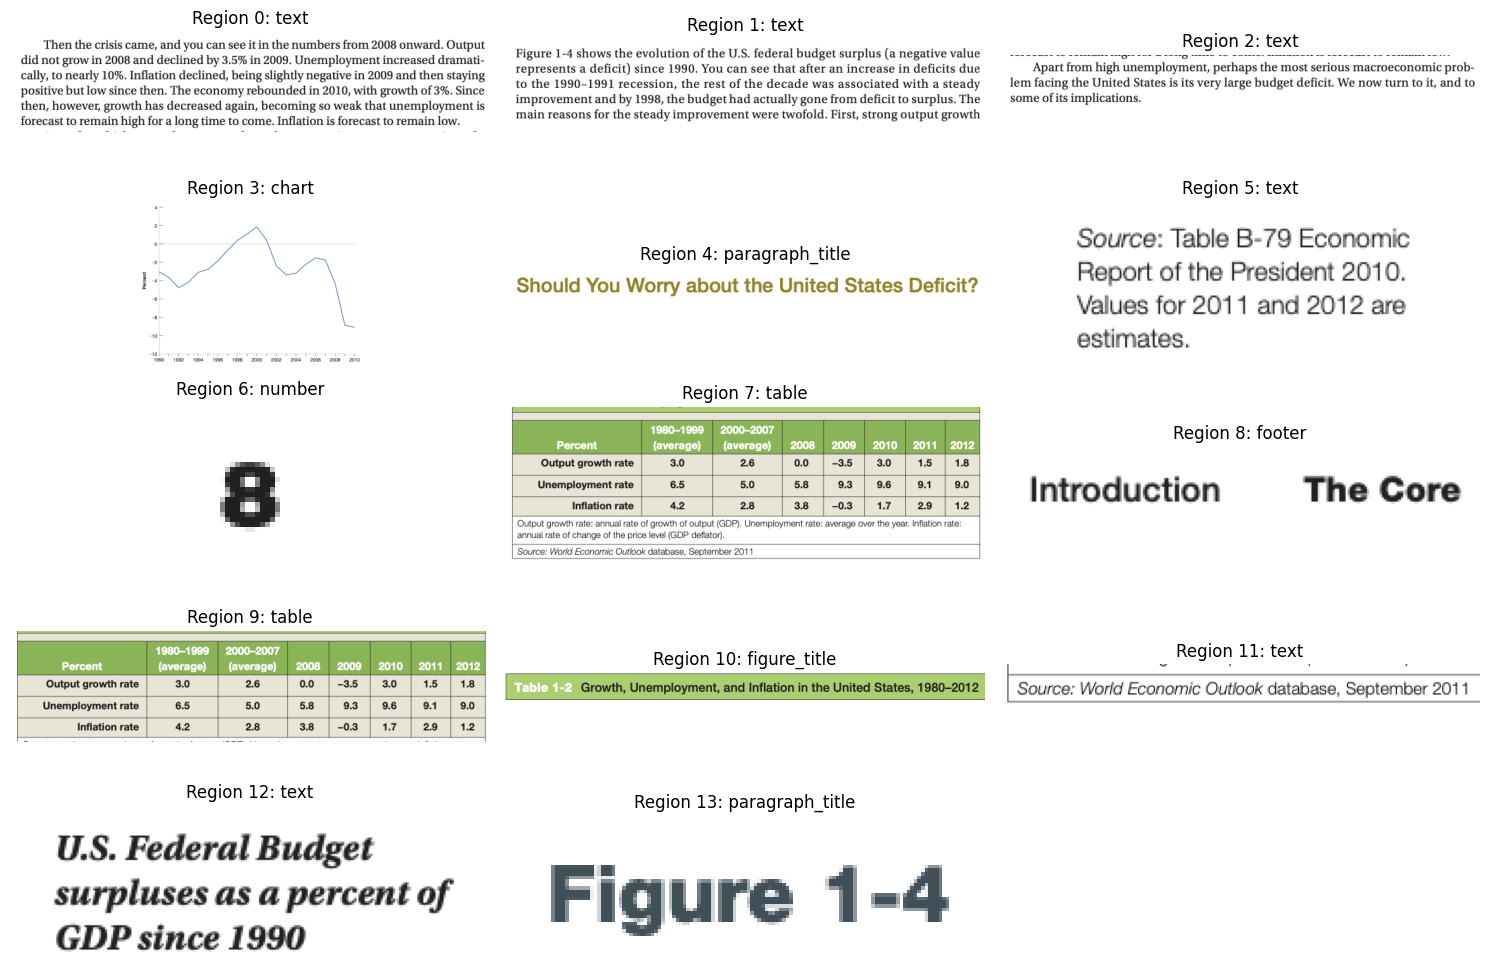

In [19]:
# Show cropped regions
fig, axes = plt.subplots(5, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (region_id, data) in enumerate(list(region_images.items())[:14]):
    axes[i].imshow(data['image'])
    axes[i].set_title(f"Region {region_id}: {data['type']}")
    axes[i].axis('off')

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

<a id="3"></a>

## Agent Tools

Create two specialized VLM tools with optimized prompts:
- **AnalyzeChart**: Interpret charts and figures
- **AnalyzeTable**: Extract structured table data

Specialized tools enable content-specific prompts and structured JSON outputs.

In [20]:
# import libraries
from langchain_core.messages import HumanMessage
from langchain.agents import create_agent
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain.tools import tool

from google.colab import userdata
GROQ_API=userdata.get('GROQ_API')
OPENAI_API=userdata.get('OPENAI_API')

vlm = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=OPENAI_API,
    temperature=0,
)

In [21]:
# VLM Helper and Prompts
CHART_ANALYSIS_PROMPT = """You are a Chart Analysis specialist.
Analyze this chart/figure image and extract:

1. **Chart Type**: (line, bar, scatter, pie, etc.)
2. **Title**: (if visible)
3. **Axes**: X-axis label, Y-axis label, and tick values
4. **Data Points**: Key values (peaks, troughs, endpoints)
5. **Trends**: Overall pattern description
6. **Legend**: (if present)

Return a JSON object with this structure:
```json
{{
  "chart_type": "...",
  "title": "...",
  "x_axis": {{"label": "...", "ticks": [...]}},
  "y_axis": {{"label": "...", "ticks": [...]}},
  "key_data_points": [...],
  "trends": "...",
  "legend": [...]
}}
```
"""

TABLE_ANALYSIS_PROMPT = """You are a Table Extraction specialist.
Extract structured data from this table image.

1. **Identify Structure**:
    - Column headers, row labels, data cells
2. **Extract All Data**:
    - Preserve exact values and alignment
3. **Handle Special Cases**:
    - Merged cells, empty cells (mark as null), multi-line headers

Return a JSON object with this structure:
```json
{{
  "table_title": "...",
  "column_headers": ["header1", "header2", ...],
  "rows": [
    {{"row_label": "...", "values": [val1, val2, ...]}},
    ...
  ],
  "notes": "any footnotes or source info"
}}
```
"""

def call_vlm_with_image(image_base64: str, prompt: str) -> str:
    """Call VLM with an image and prompt."""
    message = HumanMessage(
        content=[
            {"type": "text", "text": prompt},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/png;base64,{image_base64}"}
            }
        ]
    )
    response = vlm.invoke([message])
    return response.content

# Creating the AnalyzeChart Tool
@tool
def AnalyzeChart(region_id: int) -> str:
    """Analyze a chart or figure region using VLM.
    Use this tool when you need to extract data from charts, graphs, or figures.

    Args:
        region_id: The ID of the layout region to analyze (must be a chart/figure type)

    Returns:
        JSON string with chart type, axes, data points, and trends
    """
    if region_id not in region_images:
        return f"Error: Region {region_id} not found. Available regions: {list(region_images.keys())}"

    region_data = region_images[region_id]

    if region_data['type'] not in ['chart', 'figure']:
        return f"Warning: Region {region_id} is type '{region_data['type']}', not a chart/figure. Proceeding anyway."

    result = call_vlm_with_image(region_data['base64'], CHART_ANALYSIS_PROMPT)

    return result

print("AnalyzeChart tool defined")


# Creating the AnalyzeTable Tool
@tool
def AnalyzeTable(region_id: int) -> str:
    """
    Extract structured data from a table region using VLM.
    Use this tool when you need to extract tabular data
    with headers and rows.

    Args:
        region_id: The ID of the layout region to analyze (must be a table type)

    Returns:
        JSON string with table headers, rows, and any notes
    """
    if region_id not in region_images:
        return f"Error: Region {region_id} not found. Available regions: {list(region_images.keys())}"

    region_data = region_images[region_id]

    if region_data['type'] != 'table':
        return f"Warning: Region {region_id} is type '{region_data['type']}', not a table. Proceeding anyway."

    result = call_vlm_with_image(region_data['base64'], TABLE_ANALYSIS_PROMPT)
    return result

print("AnalyzeTable tool defined")

AnalyzeChart tool defined
AnalyzeTable tool defined


In [22]:
# Test the tools
print("Testing AnalyzeChart...")
chart_regions = [r for r in layout_regions if r.region_type in ['chart', 'figure']]
if chart_regions:
    test_result = AnalyzeChart.invoke({"region_id": chart_regions[0].region_id})
    print(f"Chart analysis result:\n{test_result[:500]}...")
else:
    print("No chart regions found")

Testing AnalyzeChart...
Chart analysis result:
```json
{
  "chart_type": "line",
  "title": "",
  "x_axis": {
    "label": "Year",
    "ticks": [1990, 1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010]
  },
  "y_axis": {
    "label": "Percent",
    "ticks": [-12, -10, -8, -6, -4, -2, 0, 2, 4]
  },
  "key_data_points": [
    {"year": 1990, "value": -4},
    {"year": 2000, "value": 2},
    {"year": 2002, "value": -4},
    {"year": 2008, "value": -10}
  ],
  "trends": "The chart shows a fluctuating trend with a peak around 2000, follow...


In [23]:
# Test table tool
print("Testing AnalyzeTable...")
table_regions = [r for r in layout_regions if r.region_type == 'table']
if table_regions:
    test_result = AnalyzeTable.invoke({"region_id": table_regions[0].region_id})
    print(f"Table analysis result:\n{test_result[:500]}...")
else:
    print("No table regions found")

Testing AnalyzeTable...
Table analysis result:
```json
{
  "table_title": "Economic Indicators",
  "column_headers": ["Percent", "1980–1999 (average)", "2000–2007 (average)", "2008", "2009", "2010", "2011", "2012"],
  "rows": [
    {"row_label": "Output growth rate", "values": [3.0, 2.6, 0.0, -3.5, 3.0, 1.5, 1.8]},
    {"row_label": "Unemployment rate", "values": [6.5, 5.0, 5.8, 9.3, 9.6, 9.1, 9.0]},
    {"row_label": "Inflation rate", "values": [4.2, 2.8, 3.8, -0.3, 1.7, 2.9, 1.2]}
  ],
  "notes": "Output growth rate: annual rate of growth ...


In [24]:
ordered_text[0]

{'position': 0,
 'text': 'Table 1-2 Growth, Unemployment, and Inflation in the United States, 19802012',
 'confidence': 0.9769929647445679,
 'bbox': [221, 7, 986, 44]}

In [27]:
layout_regions[4]

LayoutRegion(region_id=4, region_type='paragraph_title', bbox=[247, 550, 857, 573], confidence=0.9260664582252502)

##  LangChain Agent

Build the agent to orchestrate all components:
1. Receive question about document
2. Read system prompt with OCR text and layout info
3. Decide whether to answer from text or use tools
4. Call appropriate tools for visual content
5. Combine information into coherent response

In [28]:
#Prepare context for the agent
def format_ordered_text(ordered_text, max_items=50):
    """Format ordered text for the system prompt."""
    lines = []
    for item in ordered_text[:max_items]:
        lines.append(f"[{item['position']}] {item['text']}")

    if len(ordered_text) > max_items:
        lines.append(f"... and {len(ordered_text) - max_items} more text regions")

    return "\n".join(lines)

def format_layout_regions(layout_regions):
    """Format layout regions for the system prompt."""
    lines = []
    for region in layout_regions:
        lines.append(f"  - Region {region.region_id}: {region.region_type} (confidence: {region.confidence:.3f})")
    return "\n".join(lines)

# Create the formatted strings
ordered_text_str = format_ordered_text(ordered_text)
layout_regions_str = format_layout_regions(layout_regions)

print("Formatted context for agent:")
print(f"- Ordered text: {len(ordered_text_str)} chars")
print(f"- Layout regions: {len(layout_regions_str)} chars")

Formatted context for agent:
- Ordered text: 1584 chars
- Layout regions: 626 chars


In [35]:
# System prompt for the agent
SYSTEM_PROMPT = f"""You are a Document Intelligence Agent.
You analyze documents by combining OCR text with visual analysis tools.

## Document Text (in reading order)
The following text was extracted using OCR and ordered using LayoutLM.

{ordered_text_str}

## Document Layout Regions
The following regions were detected in the document:

{layout_regions_str}

## Your Tools
- **AnalyzeChart(region_id)**:
    - Use for chart/figure regions to extract data points, axes, and trends
- **AnalyzeTable(region_id)**:
    - Use for table regions to extract structured tabular data

## Instructions
1. For TEXT regions:
    - Use the OCR text provided above (it's already extracted)
2. For TABLE regions:
    - Use the AnalyzeTable tool to get structured data
3. For CHART/FIGURE regions:
    - Use the AnalyzeChart tool to extract visual data

When answering questions about the document,
use the appropriate tools to get accurate information.
"""

print("System prompt created")
print(f"Total length: {len(SYSTEM_PROMPT)} characters")


# Initialize the agent (using LangChain 0.1.x API)
tools = [AnalyzeChart, AnalyzeTable]

# LLM for the agent
agent_llm = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=OPENAI_API,
    temperature=0
    )

from langchain.agents import create_agent


tools = [AnalyzeChart, AnalyzeTable]

# 4. Create the tool-calling agent
agent = create_agent(
    model=agent_llm,
    tools=tools,
    system_prompt=SYSTEM_PROMPT
)


System prompt created
Total length: 3093 characters


**Test 1: Document Overview**

Ask a general question answerable from OCR text alone (no tool calls needed).

In [36]:
task = """
What types of content are in this document?
List the main sections.
"""
inputs = {"messages": [HumanMessage(content=task)]}
response = agent.invoke(inputs)

print(response['messages'][-1].content)

The document contains the following types of content:

1. **Table**: It includes a table presenting data on growth, unemployment, and inflation in the United States from 1980 to 2012.
2. **Text**: There are paragraphs providing explanations and analyses related to the data presented in the table.
3. **Figure/Chart**: There is a figure that shows the evolution of the U.S. federal budget surplus (or deficit) since 1990.

The main sections of the document are:

1. **Table 1-2**: Growth, Unemployment, and Inflation in the United States, 1980-2012
2. **Analysis of Economic Data**: Discussion on output growth, unemployment, and inflation rates from 2008 onward.
3. **Section Title**: "Should You Worry about the United States Deficit?" 
4. **Figure 1-4**: Evolution of the U.S. federal budget surplus/deficit since 1990.


**Test 2: Table Data Extraction**

Extract table data by calling the `AnalyzeTable` tool. Verbose output shows reasoning.

In [37]:
task = """
Extract the data from the table in this document.
Return it in a structured format.
"""
inputs = {"messages": [HumanMessage(content=task)]}
response = agent.invoke(inputs)

print(response['messages'][-1].content)

Here is the structured data extracted from the table in the document:

### Economic Indicators

| Indicator               | Percent | 1980–1999 (average) | 2000–2007 (average) | 2008 | 2009 | 2010 | 2011 | 2012 |
|------------------------|---------|---------------------|---------------------|------|------|------|------|------|
| Output growth rate     |         | 3.0                 | 2.6                 | 0.0  | -3.5 | 3.0  | 1.5  | 1.8  |
| Unemployment rate      |         | 6.5                 | 5.0                 | 5.8  | 9.3  | 9.6  | 9.1  | 9.0  |
| Inflation rate         |         | 4.2                 | 2.8                 | 3.8  | -0.3 | 1.7  | 2.9  | 1.2  |

**Notes:**
- Output growth rate: annual rate of growth of output (GDP).
- Unemployment rate: average over the year.
- Inflation rate: annual rate of change of the price level (GDP deflator).
- Source: World Economic Outlook database, September 2011.


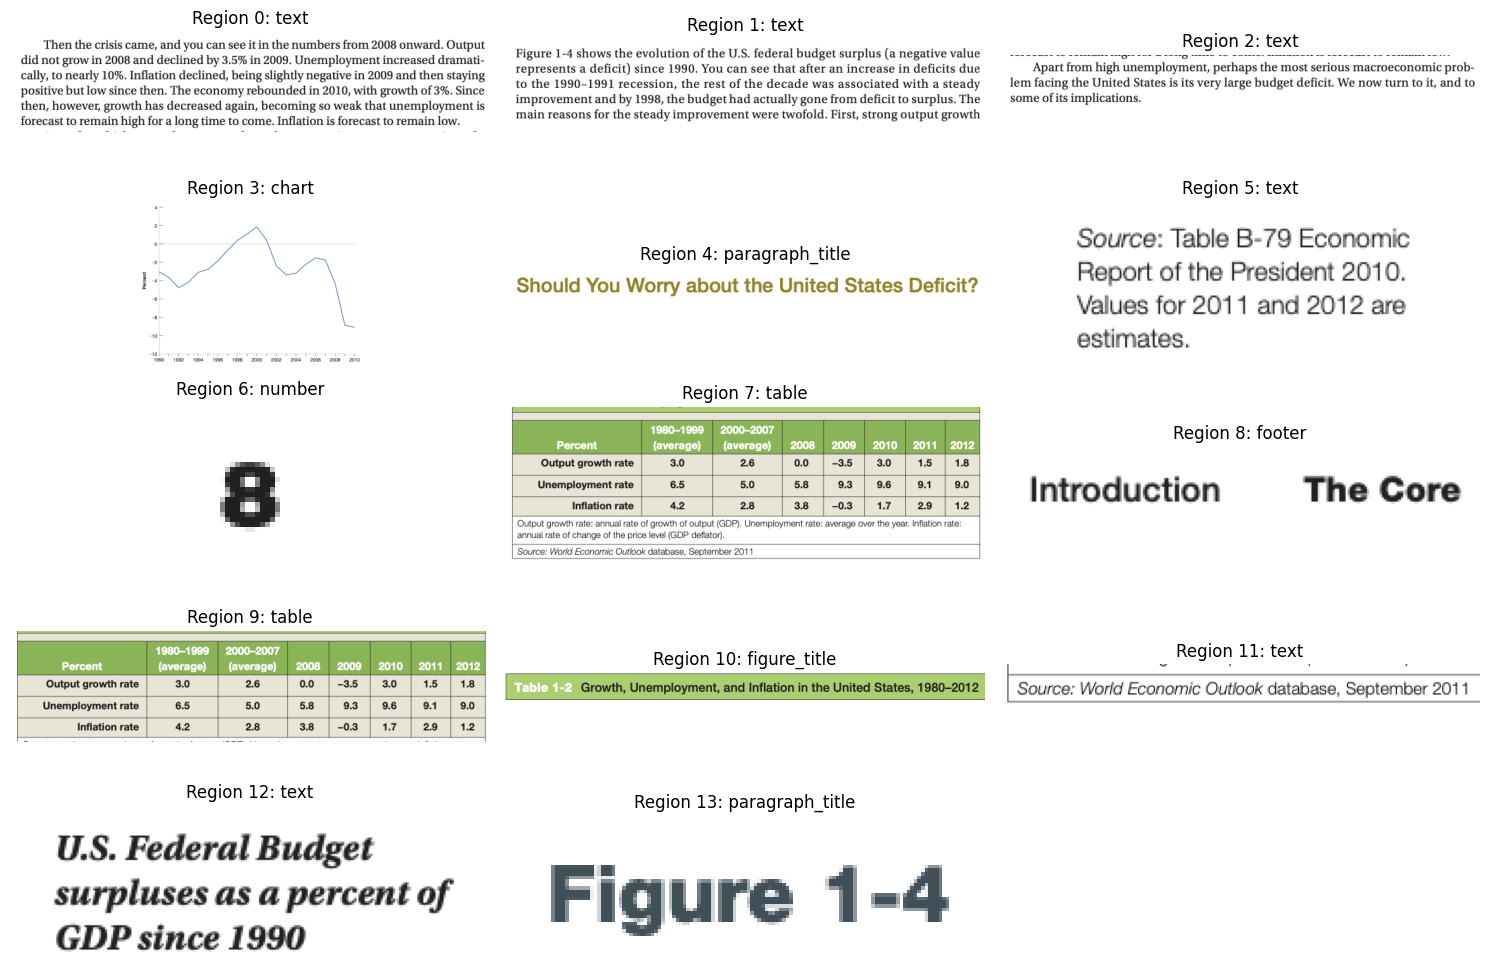

In [39]:
# Show cropped regions
fig, axes = plt.subplots(5, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (region_id, data) in enumerate(list(region_images.items())[:14]):
    axes[i].imshow(data['image'])
    axes[i].set_title(f"Region {region_id}: {data['type']}")
    axes[i].axis('off')

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**Test 3: Chart Analysis**

Analyze the chart using the `AnalyzeChart` tool to extract visual information unavailable from OCR text.

In [40]:
task = """
Analyze the chart/figure in this document.
What trends does it show?
"""
inputs = {"messages": [HumanMessage(content=task)]}
response = agent.invoke(inputs)

print(response['messages'][-1].content)

The chart is a line graph that illustrates the evolution of the U.S. federal budget surplus (with negative values representing a deficit) from 1990 to 2010. 

### Key Trends:
- **Fluctuating Trend**: The chart shows a fluctuating trend over the years.
- **Peak Around 2000**: There is a notable peak around the year 2000, where the budget surplus reached 2%.
- **Decline Towards 2008**: Following the peak, there is a significant decline, with the budget deficit reaching -10% by 2008.

### Axes:
- **X-Axis**: Represents the years from 1990 to 2010.
- **Y-Axis**: Represents the percentage of the budget surplus/deficit, ranging from -12% to 4%.

Overall, the chart indicates that the U.S. federal budget situation worsened significantly leading up to 2008, reflecting increasing deficits.


## Summary

Our hybrid approach breaks documents into separate regions of text, charts or tables. The LangChain agent uses different tools for each region.

| Component | Purpose | Output |
|-----------|---------|--------|
| **PaddleOCR** | Text Parsing | Text + bounding boxes|
| **LayoutReader** | Reading order prediction | Sorted sequence of regions |
| **PaddleOCR** | Layout Detection | Region types (table, chart, text) |
| **VLM** | Analysis of charts/tables | JSON (title, legend,... / headers, rows,...) |
